<a href="https://colab.research.google.com/github/1eetnals/Body-Morphometry-kidney-and-tumor/blob/main/reverse_test_label.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
    MapTransform,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 0.6.0
Numpy version: 1.20.1
Pytorch version: 1.9.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 3.13.0
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.1.2
tqdm version: 4.59.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.2.4
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
test_path = '/Users/hufsbme/gyu/test/'
Input_folder = os.listdir(test_path)
test_files = []

for i in range(0,len(Input_folder)):
    if Input_folder[i].endswith('.nii.gz'):
        test_files.append(test_path+Input_folder[i])

test_files.sort()
test_files

['/Users/hufsbme/gyu/test/test001.nii.gz',
 '/Users/hufsbme/gyu/test/test002.nii.gz',
 '/Users/hufsbme/gyu/test/test003.nii.gz',
 '/Users/hufsbme/gyu/test/test004.nii.gz',
 '/Users/hufsbme/gyu/test/test005.nii.gz',
 '/Users/hufsbme/gyu/test/test006.nii.gz',
 '/Users/hufsbme/gyu/test/test007.nii.gz',
 '/Users/hufsbme/gyu/test/test008.nii.gz',
 '/Users/hufsbme/gyu/test/test009.nii.gz',
 '/Users/hufsbme/gyu/test/test010.nii.gz',
 '/Users/hufsbme/gyu/test/test011.nii.gz',
 '/Users/hufsbme/gyu/test/test012.nii.gz',
 '/Users/hufsbme/gyu/test/test013.nii.gz',
 '/Users/hufsbme/gyu/test/test014.nii.gz',
 '/Users/hufsbme/gyu/test/test015.nii.gz',
 '/Users/hufsbme/gyu/test/test016.nii.gz',
 '/Users/hufsbme/gyu/test/test017.nii.gz',
 '/Users/hufsbme/gyu/test/test018.nii.gz',
 '/Users/hufsbme/gyu/test/test019.nii.gz',
 '/Users/hufsbme/gyu/test/test020.nii.gz',
 '/Users/hufsbme/gyu/test/test021.nii.gz',
 '/Users/hufsbme/gyu/test/test022.nii.gz',
 '/Users/hufsbme/gyu/test/test023.nii.gz',
 '/Users/hu

In [ ]:
test_ind=np.arange(0,len(test_files))
data_dicts=[
    {
        "image": test_files[idx],
    }
    for idx in test_ind
]

test_f=data_dicts
len(test_f)
test_f

[{'image': '/Users/hufsbme/gyu/test/test001.nii.gz'},
 {'image': '/Users/hufsbme/gyu/test/test002.nii.gz'},
 {'image': '/Users/hufsbme/gyu/test/test003.nii.gz'},
 {'image': '/Users/hufsbme/gyu/test/test004.nii.gz'},
 {'image': '/Users/hufsbme/gyu/test/test005.nii.gz'},
 {'image': '/Users/hufsbme/gyu/test/test006.nii.gz'},
 {'image': '/Users/hufsbme/gyu/test/test007.nii.gz'},
 {'image': '/Users/hufsbme/gyu/test/test008.nii.gz'},
 {'image': '/Users/hufsbme/gyu/test/test009.nii.gz'},
 {'image': '/Users/hufsbme/gyu/test/test010.nii.gz'},
 {'image': '/Users/hufsbme/gyu/test/test011.nii.gz'},
 {'image': '/Users/hufsbme/gyu/test/test012.nii.gz'},
 {'image': '/Users/hufsbme/gyu/test/test013.nii.gz'},
 {'image': '/Users/hufsbme/gyu/test/test014.nii.gz'},
 {'image': '/Users/hufsbme/gyu/test/test015.nii.gz'},
 {'image': '/Users/hufsbme/gyu/test/test016.nii.gz'},
 {'image': '/Users/hufsbme/gyu/test/test017.nii.gz'},
 {'image': '/Users/hufsbme/gyu/test/test018.nii.gz'},
 {'image': '/Users/hufsbme/g

In [ ]:
test_transforms1 = Compose(
    [
        LoadImaged(keys=["image"]),
        AddChanneld(keys=["image"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        ToTensord(keys=["image"]),
    ]
)

test_transforms2 = Compose(
    [
        LoadImaged(keys=["image"]),
        AddChanneld(keys=["image"]),
        Orientationd(keys=["image"], axcodes="RPS"),
        ToTensord(keys=["image"]),
    ]
)

In [ ]:
'''test_ds1 = CacheDataset(
    data=test_f, transform=test_transforms1,cache_rate=1.0, num_workers=0
)
test_loader1 = DataLoader(
    test_ds1, batch_size=1, shuffle=False, num_workers=0, pin_memory=True
)'''

test_ds2 = CacheDataset(
    data=test_f, transform=test_transforms2, cache_rate=1.0, num_workers=0
)
test_loader2 = DataLoader(
    test_ds2, batch_size=1, shuffle=False, num_workers=0, pin_memory=True
)

Loading dataset: 100%|██████████| 83/83 [00:53<00:00,  1.54it/s]


image shape: torch.Size([1, 1, 512, 512, 64])


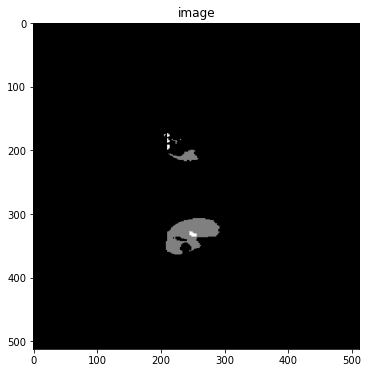

image shape: torch.Size([1, 1, 512, 512, 64])


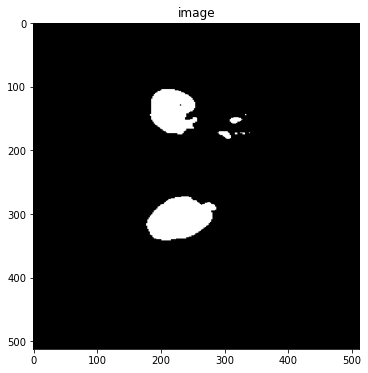

image shape: torch.Size([1, 1, 512, 512, 64])


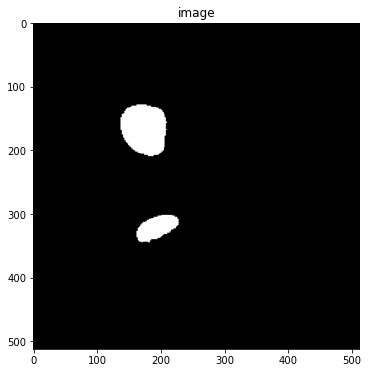

In [ ]:
i = 0
for test_image1 in test_loader1:
#img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    img = test_image1["image"]
    img_shape = img.shape
    print(f"image shape: {img_shape}")

    plt.figure("image", (18, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(img[0,0, :, :, 20].detach().cpu(), cmap="gray")
    plt.show()
    i+=1
    if i==3:
        break


image shape: torch.Size([1, 1, 512, 512, 64])


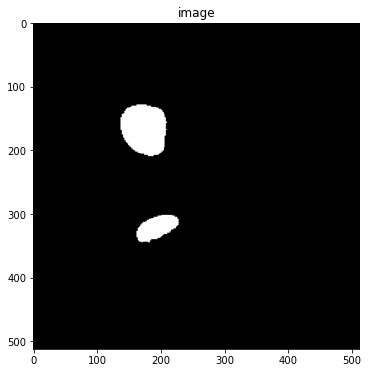

image shape: torch.Size([1, 1, 512, 512, 64])


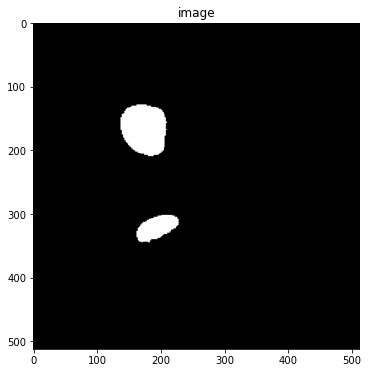

image shape: torch.Size([1, 1, 512, 512, 64])


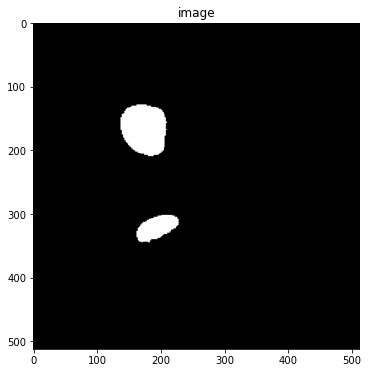

In [ ]:
i = 0
for test_image2 in test_loader2:
#img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    img = test_image1["image"]
    img_shape = img.shape
    print(f"image shape: {img_shape}")

    plt.figure("image", (18, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(img[0,0, :, :, 20].detach().cpu(), cmap="gray")
    plt.show()
    i+=1
    if i==3:
        break

In [ ]:
out_dir='/Users/hufsbme/gyu/reversed'
import nibabel as nib

In [ ]:
case_num=1
for test_label in test_loader2:
#img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    img = test_label["image"]
    #test_inputs = torch.unsqueeze(img, 1).to(device)
    test_inputs=img
    
    print(test_inputs.shape)
    ##print(val_outputs)
    
    ##print('#####')
    ##print(val_outputs_new)
    h1=nib.Nifti1Image(test_inputs.cpu().numpy()[0,0],test_label['image_meta_dict']['affine'][0])
    if case_num<10:
        nib.save(h1,os.path.join(out_dir,f'test00{case_num}.nii.gz'))
    else :
        nib.save(h1,os.path.join(out_dir,f'test0{case_num}.nii.gz'))
    case_num+=1
    

torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size([1, 1, 512, 512, 64])
torch.Size